In [14]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import QTable
import numpy as np
from reproject import reproject_interp
import os 
from tqdm import tqdm 
from astropy.table import join

import warnings
warnings.filterwarnings('ignore')

# plt.style.use('paper.mplstyle')
from imports import *

In [15]:
def plot_median_with_percentile_error(ax, data, y=0.07, color1='C0', color2='C0', marker='s',
                                      error_linewidth=2, capsize=5, capthick=2, scatter_linewidth=1.75,
                                      label='All MUSE nebulae'):
    """
    Plot the median of `data` with error bars representing the 16th and 84th percentiles on a given axis.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    data : array-like
        The data from which to compute the median and percentile ranges.
    y : float, optional
        The y-coordinate at which to plot the marker and error bar (default is 0.07).
    color1 : str, optional
        Color for the error bars and marker edge (default is 'C0').
    color2 : str, optional
        Color for the marker face (default is 'C0').
    marker : str, optional
        Marker style for the median point (default is 's').
    error_linewidth : float, optional
        Line width for the error bar (default is 2).
    capsize : float, optional
        The length of the error bar caps in points (default is 5).
    capthick : float, optional
        The thickness of the error bar caps (default is 2).
    scatter_linewidth : float, optional
        The line width for the scatter marker edge (default is 1.75).
    """
    # Compute the median and the 16th and 84th percentiles
    median = np.nanmedian(data)
    p16, p84 = np.nanpercentile(data, [16, 84])
    err_low = median - p16  # Distance from median to 16th percentile
    err_high = p84 - median  # Distance from median to 84th percentile

    # Plot the median with asymmetric error bars representing the 16th and 84th percentiles
    ax.errorbar(median, y, xerr=[[err_low], [err_high]], elinewidth=error_linewidth, 
                capsize=capsize, capthick=capthick, zorder=5, color=color1)
    ax.scatter([median], [y], marker=marker, ec=color1, fc=color2, 
               zorder=5, linewidths=scatter_linewidth, label=label)
    
    return

In [2]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'

# table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
# table_wprops = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_wprops.fits' %root_dir)
# table_wasso = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations.fits' %root_dir)

table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_fixediso_10pc.fits' %root_dir)
table_wprops = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_wprops_fixediso_10pc.fits' %root_dir)
table_wasso = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_fixediso_10pc.fits' %root_dir)

table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir)
table_muse_masked = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3_HSTFOV.fits' %root_dir)

table = table[(table['flag_star_MUSE']!=1) & (table['flag_edge_MUSE']!=1) & (table["flag_edge_hst"]!=1)] # remove stars and edge objects
table_wprops = table_wprops[(table_wprops['flag_star_MUSE']!=1) & (table_wprops['flag_edge_MUSE']!=1) & (table_wprops["flag_edge_hst"]!=1)] # remove stars and edge objects
table_wasso = table_wasso[(table_wasso['flag_star_MUSE']!=1) & (table_wasso['flag_edge_MUSE']!=1) & (table_wasso["flag_edge_hst"]!=1)] # remove stars and edge objects
table_muse = table_muse[(table_muse['flag_star']!=1) & (table_muse['flag_edge']!=1)] # remove stars and edge objects

mask_hii = table_wasso['HII_class_v3_MUSE']==1
mask_noasso = ~table_wasso['no_associations_association_nuv_32pc']
table_wasso = table_wasso[mask_noasso&mask_hii]

if len(table) != len(table_wprops):
    print('Warning: Tables are not the same length!')

In [3]:
table

gal_name,region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,complexity_score_leaves,complexity_rms,complexity_std,flag_edge_hst,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE,flag_touch_hst,cen_x_MUSE,cen_y_MUSE,cen_ra_MUSE,cen_dec_MUSE,cen_x_geo_MUSE,cen_y_geo_MUSE,flag_edge_MUSE,flag_nearby_MUSE,flag_star_MUSE,deproj_dist_MUSE,deproj_phi_MUSE,region_area_MUSE,region_circ_rad_MUSE,HB4861_FLUX_MUSE,OIII5006_FLUX_MUSE,HA6562_FLUX_MUSE,NII6583_FLUX_MUSE,SII6716_FLUX_MUSE,SII6730_FLUX_MUSE,SIII9068_FLUX_MUSE,OI6300_FLUX_MUSE,NII5754_FLUX_MUSE,HEI5875_FLUX_MUSE,SIII6312_FLUX_MUSE,OI6363_FLUX_MUSE,OII7319_FLUX_MUSE,OII7330_FLUX_MUSE,HB4861_FLUX_ERR_MUSE,OIII5006_FLUX_ERR_MUSE,HA6562_FLUX_ERR_MUSE,NII6583_FLUX_ERR_MUSE,SII6716_FLUX_ERR_MUSE,SII6730_FLUX_ERR_MUSE,SIII9068_FLUX_ERR_MUSE,OI6300_FLUX_ERR_MUSE,NII5754_FLUX_ERR_MUSE,HEI5875_FLUX_ERR_MUSE,SIII6312_FLUX_ERR_MUSE,OI6363_FLUX_ERR_MUSE,OII7319_FLUX_ERR_MUSE,OII7330_FLUX_ERR_MUSE,HA6562_SIGMA_MUSE,NII6583_SIGMA_MUSE,OIII5006_SIGMA_MUSE,HA6562_VEL_MUSE,NII6583_VEL_MUSE,OIII5006_VEL_MUSE,HA6562_SIGMA_ERR_MUSE,NII6583_SIGMA_ERR_MUSE,OIII5006_SIGMA_ERR_MUSE,HA6562_VEL_ERR_MUSE,NII6583_VEL_ERR_MUSE,OIII5006_VEL_ERR_MUSE,HB4861_FLUX_CORR_MUSE,OIII5006_FLUX_CORR_MUSE,HA6562_FLUX_CORR_MUSE,NII6583_FLUX_CORR_MUSE,SII6716_FLUX_CORR_MUSE,SII6730_FLUX_CORR_MUSE,SIII9068_FLUX_CORR_MUSE,OI6300_FLUX_CORR_MUSE,NII5754_FLUX_CORR_MUSE,HEI5875_FLUX_CORR_MUSE,SIII6312_FLUX_CORR_MUSE,OI6363_FLUX_CORR_MUSE,OII7319_FLUX_CORR_MUSE,OII7330_FLUX_CORR_MUSE,HB4861_FLUX_CORR_ERR_MUSE,OIII5006_FLUX_CORR_ERR_MUSE,HA6562_FLUX_CORR_ERR_MUSE,NII6583_FLUX_CORR_ERR_MUSE,SII6716_FLUX_CORR_ERR_MUSE,SII6730_FLUX_CORR_ERR_MUSE,SIII9068_FLUX_CORR_ERR_MUSE,OI6300_FLUX_CORR_ERR_MUSE,NII5754_FLUX_CORR_ERR_MUSE,HEI5875_FLUX_CORR_ERR_MUSE,SIII6312_FLUX_CORR_ERR_MUSE,OI6363_FLUX_CORR_ERR_MUSE,OII7319_FLUX_CORR_ERR_MUSE,OII7330_FLUX_CORR_ERR_MUSE,EBV_MUSE,EBV_ERR_MUSE,met_scal_MUSE,met_scal_err_MUSE,logq_D91_MUSE,logq_D91_err_MUSE,BPT_NII_MUSE,BPT_SII_MUSE,BPT_OI_MUSE,LOG_SIGMA_SFR_CHAB_MUSE,LOG_SIGMA_STMASS_CHAB_MUSE,5thNN_dist_MUSE,NN_number_MUSE,Environment_MUSE,r_R25_MUSE,r_reff_MUSE,HA6562_LUMINOSITY_MUSE,Delta_met_scal_MUSE,pc_per_pixel_MUSE,EW_HA6562_MUSE,EW_HA6562_ERR_MUSE,EW_HB4861_MUSE,EW_HB4861_ERR_MUSE,HII_class_v2_MUSE,HII_class_v3_MUSE,FLAG_NII5754_MUSE,FLAG_SIII6312_MUSE,FLAG_OII7320_MUSE,FLAG_OII7330_MUSE,TEM_NII_MUSE,TEM_NII_ERR_MUSE,TEM_SIII_MUSE,TEM_SIII_ERR_MUSE
,,pix,pix,pix,pix,deg,deg,deg,deg,pix,erg / (s cm2),erg / (s cm2),arcsec2,arcsec,erg / (s cm2),erg / (s cm2),erg / (s cm2),pc,pix,pix,deg,deg,arcsec2,arcsec,arcsec,arcsec,deg,pc,,,,,,,,,,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,erg / (s cm2),erg / (s cm2),erg / s,erg / s,pc,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,,,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),,,erg 

In [4]:
# Return if the region in the MUSE catalogue is detected in the HST catalogue
# Then append this to the MUSE catalogue (such that we have MUSE catalogue + detection flag)

run_detections = True
if run_detections: 
    
    detections_all = []
    gal_names = np.unique(table_muse_masked['gal_name'])
    for gal_name in tqdm(gal_names): 

        table_muse_masked_gal = table_muse_masked[table_muse_masked['gal_name'] == gal_name]
        table_hst_gal = table[table['gal_name'] == gal_name]

        region_IDs = table_muse_masked_gal['region_ID']
        detections = np.ones(len(region_IDs), dtype=bool)

        for i, region_ID in enumerate(region_IDs):

            if region_ID not in table_hst_gal['region_ID']:
                detection = False
            else : 
                detection = True

            detections[i] = detection

        detections_all += [detections]

    detections_all = np.concatenate(detections_all)
    table_muse_masked.add_column(detections_all, name='detection')

100%|██████████| 19/19 [00:00<00:00, 19.30it/s]


In [5]:
def get_completeness(xdata, ydata=None, binlims=None, bincent=None, nbins=20, dolog=True):

    if ydata is None:
        ydata = np.ones(len(xdata))

    if dolog:
        xdata = np.log10(np.array(xdata))

    if binlims is None:

        binmin = np.nanmin(xdata)
        binmax = np.nanmax(xdata)
        nbins = 20

        binlims = np.linspace(binmin, binmax, nbins)

    nbins = len(binlims)
    bincent = binlims[:-1]+((binlims[1:] - binlims[:-1])/2)
    
    sum_value_bin = np.zeros(nbins-1)*np.nan         # total value of regions in each bin
    sum_n_bins = np.zeros(nbins-1)*np.nan           # number of detections in each bin
    # tot_value_bins = np.zeros(nbins-1)*np.nan       
    tot_n_bins = np.zeros(nbins-1)*np.nan  
    frac_n_bins = np.zeros(nbins-1)*np.nan           # fraction of detections in each bin    

    for i in range(len(bincent)): 
        
        mask = (xdata>binlims[i]) & (xdata<binlims[i+1])

        xdata_bin = xdata[mask]
        ydata_bin = ydata[mask]

        if dolog:
            sum_value_bin[i] = np.log10(np.nansum(10**xdata_bin)) # total value of regions in each bin (log space)
            if not np.isfinite(sum_value_bin[i]):
                sum_value_bin[i] = np.nan
        else: 
            sum_value_bin[i] = np.nansum(xdata_bin) # total value of regions in each bin
        sum_n_bins[i] = np.nansum(ydata_bin*1) # number of detections in each bin

        # tot_value_bins[i] = np.nansum(10**xdata_bin)
        tot_n_bins[i] = np.nansum(mask)  # number of regions in each bin

        frac_n_bins[i] = sum_n_bins[i]/tot_n_bins[i]
        
    return bincent, sum_value_bin, sum_n_bins, tot_n_bins, frac_n_bins, binlims

binlims = np.linspace(35, 42, 25)
Lbin_MUSE, Ltot_MUSE, L_num_MUSE, L_numtot_MUSE, Lcomp_num_MUSE, binlims = get_completeness(table_muse_masked['Lum_HA6562_CORR'], detections_all, binlims=binlims) #MUSE data
Lbin_HST, Ltot_HST, L_num_HST, L_numtot_HST, Lcomp_num_HST, _ = get_completeness(table['HA6562_LUMINOSITY_HST'], binlims=binlims, bincent=Lbin_MUSE) #HST data (all detections = 1)

# Scent, S_num, Scomp_num = get_completeness(np.log10(table_muse_masked['HA6562_FLUX']/(table_muse_masked['region_area'])*0.2**2), detections_all, nbins=15)

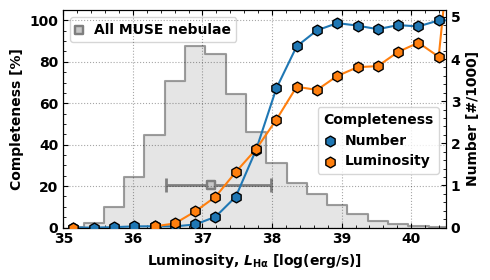

In [17]:
data_x1 = Lbin_MUSE
data_y1 = Lcomp_num_MUSE *100
data_z1 = L_numtot_MUSE/1000

data_x2 = Lbin_HST
data_y2 = 10**(Ltot_HST-Ltot_MUSE) *100

colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

fig = plt.figure(figsize=(5, 2.9)) 
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(data_x1, data_y1)
ax1.plot(data_x2, data_y2, color='C1')

ax1.scatter(data_x1, data_y1, s=60, ec='black', fc='C0', zorder=10, marker='h', lw=1, label=r'Number')
ax1.scatter(data_x1[0], data_y1[0], s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1, label=r'Luminosity')
ax1.scatter(data_x2, data_y2, s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1)

ax2.plot(data_x1, data_z1, color='grey', alpha=0.75, ds='steps-mid', zorder=0)
ax2.fill_between(data_x1, data_z1, alpha=0.2, step='mid', color='grey', zorder=0)

ax1.scatter(np.nan, np.nan, s=50, marker='s', ec=colors1[0], fc=colors2[0], label=r'')
ax1.scatter(np.nan, np.nan, s=50, marker='s', ec=colors1[1], fc=colors2[1], label=r'')

ax1.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel(r'Luminosity, $L_\mathrm{H\alpha}$ [log(erg/s)]')
ax1.set_ylabel('Completeness [%]')

ax2.set_ylabel('Number [#/1000]')

ax1.set_ylim(0, 105)
ax2.set_xlim(35, 40.5)
ax2.set_ylim(0, max(data_z1)*1.2)

# # plot medians
data1 = np.log10(table_muse_masked['Lum_HA6562_CORR'])
# median, std, mean = np.nanmedian(data1), np.nanstd(data1), np.nanmean(data1)
# ax2.errorbar(median, 1, xerr=std, elinewidth=2, capsize=5, capthick=2, zorder=5, color=colors1[7])
# ax2.scatter([median], [1], marker='s', ec=colors1[7], fc=colors2[7], zorder=5, linewidths=1.75, label='All MUSE nebulae')
# # 

plot_median_with_percentile_error(ax2, data1, y=1, color1=colors1[7], color2=colors2[7], marker='s', label='All MUSE nebulae')

ax1.legend(loc='center right', handlelength=0.5, title='Completeness', bbox_to_anchor=(0.5, 0.15, 0.5, 0.5))
ax2.legend(loc='upper left', handlelength=0.5)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax1.set_zorder(1)

ax1.patch.set_visible(False)
ax2.patch.set_visible(False)

fig.savefig('./figs/scatter_completeness.pdf', dpi=200, bbox_inches='tight')

In [7]:
from scipy.interpolate import interp1d
interp_func2 = interp1d(data_y1, data_x1)
interp_func1 = interp1d(data_y2, data_x2)

print('Luminosity completeness (05percent): %0.1f' %interp_func1(5))
print('Luminosity completeness (10percent): %0.1f' %interp_func1(10))
print('Luminosity completeness (50percent): %0.1f' %interp_func1(50))
print('Luminosity completeness (90percent): %0.1f' %interp_func1(90))

print('Number completeness (03percent): %0.1f' %interp_func2(3))
print('Number completeness (05percent): %0.1f' %interp_func2(5))
print('Number completeness (10percent): %0.1f' %interp_func2(10))
print('Number completeness (50percent): %0.1f' %interp_func2(50))
print('Number completeness (90percent): %0.1f' %interp_func2(90))

Luminosity completeness (05percent): 36.8
Luminosity completeness (10percent): 37.0
Luminosity completeness (50percent): 38.0
Luminosity completeness (90percent): 40.4
Number completeness (03percent): 37.0
Number completeness (05percent): 37.2
Number completeness (10percent): 37.3
Number completeness (50percent): 37.9
Number completeness (90percent): 38.5
